The Boston Housing Dataset
---

## Life cycle of Machine learning Project
* Understanding the Problem Statement
* Data Collection
* Data Checks to perform
* Exploratory data analysis
* Data Pre-Processing
* Model Training
* Choose best model

## Problem statement

[link](https://www.youtube.com/watch?v=fw5rkjq4Tfo&list=PLfFghEzKVmjsSdQ61kdqcfE2vgrsVJqL4&t=608)

The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston MA. The following describes the dataset columns:

+ CRIM - per capita crime rate by town
+ ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
+ INDUS - proportion of non-retail business acres per town.
+ CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
+ NOX - nitric oxides concentration (parts per 10 million)
+ RM - average number of rooms per dwelling
+ AGE - proportion of owner-occupied units built prior to 1940
+ DIS - weighted distances to five Boston employment centres
+ RAD - index of accessibility to radial highways
+ TAX - full-value property-tax rate per $10,000

+ PTRATIO - pupil-teacher ratio by town
+ B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
+ LSTAT - % lower status of the population
+ MEDV - Median value of owner-occupied homes in $1000's (price)


## Conexion Drive

In [48]:
# from google.colab import drive
# drive.mount('/gdrive')

## Librerias

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

pd.set_option('display.max_columns', None)

## **Funciones**

In [50]:
# -----------------------------
# Funciones de interpretación
# -----------------------------

# 1. Interpretación del Coeficiente de Variación (CV)
def interpret_cv(cv):
    if cv < 0.1:
        return "Muy baja dispersión, media muy representativa"
    elif cv < 0.3:
        return "Baja dispersión, media representativa"
    elif cv < 0.6:
        return "Dispersión moderada, media algo representativa"
    else:
        return "Alta dispersión, media poco representativa"

# 2. Interpretación de la Curtosis
def interpret_kurtosis(k):
    if k > 3:
        return "Distribución con picos altos y valores extremos frecuentes"
    elif k < 3:
        return "Distribución más plana, sin picos marcados ni extremos"
    else:
        return "Distribución similar a la normal, picos y extremos moderados"

# 3. Interpretación de la Asimetría
def interpret_skew(sk):
    if sk > 1:
        return "Sesgo positivo fuerte (cola derecha)"
    elif sk > 0.5:
        return "Sesgo positivo moderado (derecha)"
    elif sk > -0.5:
        return "Casi simétrica"
    elif sk > -1:
        return "Sesgo negativo moderado (izquierda)"
    else:
        return "Sesgo negativo fuerte (cola izquierda)"

# 4. Interpretación del rango intercuartílico
def interpret_iqr(row):
    iqr = row['75%'] - row['25%']
    mean_val = row['mean']

    if iqr == 0:
        return "No hay dispersión entre los valores centrales"
    elif iqr < mean_val*0.25:
        return "Poca dispersión entre los valores centrales"
    elif iqr < mean_val*0.5:
        return "Dispersión moderada entre los valores centrales"
    else:
        return "Dispersión alta entre los valores centrales"

# 5. Detectar variables dicotómicas
def is_binary(row):
    # Se asume que min y max son 0 y 1
    if row['min'] == 0 and row['max'] == 1:
        return True
    # Opcional: si tiene pocos valores diferentes respecto al count
    return False

In [51]:
# Función para detectar outliers según regla IQR
def detectar_outliers_serie(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return (serie < lim_inf) | (serie > lim_sup)

## Variables

In [52]:
path = 'https://raw.githubusercontent.com/bryanOsmar07/Data_Repository/refs/heads/main/bostonvivienda.csv'
path = 'data/bostonvivienda.csv'


# **I. Lectura Datos**

In [53]:
df_prev = pd.read_csv(path)

In [54]:
# Vista data
print(df_prev.shape)
display(df_prev.head())
display(df_prev.tail())

(506, 13)


,crim,zn,indus,nox,rm,edad,dis,rad,impuesto,ptratio,negro,lstat,medv
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


,crim,zn,indus,nox,rm,edad,dis,rad,impuesto,ptratio,negro,lstat,medv
501,0.06263,0.0,11.93,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.573,6.030,80.8,2.5050,1,273,21.0,396.90,7.88,11.9


In [55]:
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   crim      506 non-null    float64
 1   zn        506 non-null    float64
 2   indus     506 non-null    float64
 3   nox       506 non-null    float64
 4   rm        506 non-null    float64
 5   edad      506 non-null    float64
 6   dis       506 non-null    float64
 7   rad       506 non-null    int64  
 8   impuesto  506 non-null    int64  
 9   ptratio   506 non-null    float64
 10  negro     506 non-null    float64
 11  lstat     506 non-null    float64
 12  medv      506 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 51.5 KB


In [56]:
# Variables numéricas
vars_numericas = df_prev.select_dtypes(include='number').columns.tolist()

# Variables categóricas
vars_categoricas = df_prev.select_dtypes(exclude='number').columns.tolist()

# target
target = "medv"

print("Variables numéricas:", vars_numericas)
print("Variables categóricas:", vars_categoricas)

Variables numéricas: ['crim', 'zn', 'indus', 'nox', 'rm', 'edad', 'dis', 'rad', 'impuesto', 'ptratio', 'negro', 'lstat', 'medv']
Variables categóricas: []


# **II. Data Wrangling**

* Check Missing values
* Check Duplicates
* Check data type
* Check the number of unique values of each column
* Check statistics of data set
* Check various categories present in the different categorical column

In [57]:
# Vista de las categorias
for var in vars_categoricas:
  display(df_prev.groupby([var])['CLIENTE'].count())

## Missing Values

In [58]:
df_prev.isnull().sum()

crim        0
zn          0
indus       0
nox         0
rm          0
edad        0
dis         0
rad         0
impuesto    0
ptratio     0
negro       0
lstat       0
medv        0
dtype: int64

In [59]:
df_prev.duplicated().sum()

np.int64(0)

In [60]:
df_prev.nunique()

crim        504
zn           26
indus        76
nox          81
rm          446
edad        356
dis         412
rad           9
impuesto     66
ptratio      46
negro       357
lstat       455
medv        229
dtype: int64

# **III. EDA**

[Teoria](https://docs.google.com/document/d/1cnDMPLQaYGVRlHzI-1yhH9DDrLWtacflWd0vXvPkpro/edit?tab=t.0#heading=h.nd0kbqehgk2)

In [61]:
resumen = df_prev[vars_numericas].describe().T
resumen['CV'] = resumen['std'] / resumen['mean']
resumen['asimetria'] = df_prev[vars_numericas].skew()
resumen['Asimetria_Pearson'] = (3 * (resumen['mean'] - resumen['50%'])) / resumen['std']
resumen['Kurtosis'] = df_prev[vars_numericas].kurtosis()

# Explicacion de estadisticos
resumen['Interpretacion_CV'] = resumen['CV'].apply(interpret_cv)
resumen['Interpretacion_Curtosis'] = resumen['Kurtosis'].apply(interpret_kurtosis)
resumen['Interpretacion_Asimetria'] = resumen['asimetria'].apply(interpret_skew)
resumen['Rango_Intercuartil'] = resumen.apply(interpret_iqr, axis=1)
resumen['Es_Dicotomica'] = resumen.apply(is_binary, axis=1)

resumen = resumen.round(3)
resumen

,count,mean,std,min,25%,50%,75%,max,CV,asimetria,Asimetria_Pearson,Kurtosis,Interpretacion_CV,Interpretacion_Curtosis,Interpretacion_Asimetria,Rango_Intercuartil,Es_Dicotomica
crim,506.0,3.614,8.602,0.006,0.082,0.257,3.677,88.976,2.380,5.223,1.171,37.131,"Alta dispersión, media poco representativa",Distribución con picos altos y valores extremo...,Sesgo positivo fuerte (cola derecha),Dispersión alta entre los valores centrales,False
zn,506.0,11.364,23.322,0.000,0.000,0.000,12.500,100.000,2.052,2.226,1.462,4.032,"Alta dispersión, media poco representativa",Distribución con picos altos y valores extremo...,Sesgo positivo fuerte (cola derecha),Dispersión alta entre los valores centrales,False
indus,506.0,11.137,6.860,0.460,5.190,9.690,18.100,27.740,0.616,0.295,0.633,-1.234,"Alta dispersión, media poco representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Dispersión alta entre los valores centrales,False
nox,506.0,0.555,0.116,0.385,0.449,0.538,0.624,0.871,0.209,0.729,0.432,-0.065,"Baja dispersión, media representativa","Distribución más plana, sin picos marcados ni ...",Sesgo positivo moderado (derecha),Dispersión moderada entre los valores centrales,False
rm,506.0,6.285,0.703,3.561,5.885,6.208,6.624,8.780,0.112,0.404,0.325,1.892,"Baja dispersión, media representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Poca dispersión entre los valores centrales,False
edad,506.0,68.575,28.149,2.900,45.025,77.500,94.075,100.000,0.410,-0.599,-0.951,-0.968,"Dispersión moderada, media algo representativa","Distribución más plana, sin picos marcados ni ...",Sesgo negativo moderado (izquierda),Dispersión alta entre los valores centrales,False
dis,506.0,3.795,2.106,1.130,2.100,3.207,5.188,12.126,0.555,1.012,0.837,0.488,"Dispersión moderada, media algo representativa","Distribución más plana, sin picos marcados ni ...",Sesgo positivo fuerte (cola derecha),Dispersión alta entre los valores centrales,False
rad,506.0,9.549,8.707,1.000,4.000,5.000,24.000,24.000,0.912,1.005,1.567,-0.867,"Alta dispersión, media poco representativa","Distribución más plana, sin picos marcados ni ...",Sesgo positivo fuerte (cola derecha),Dispersión alta entre los valores centrales,False
impuesto,506.0,408.237,168.537,187.000,279.000,330.000,666.000,711.000,0.413,0.670,1.393,-1.142,"Dispersión moderada, media algo representativa","Distribución más plana, sin picos marcados ni ...",Sesgo positivo moderado (derecha),Dispersión alta entre los valores centrales,False
ptratio,506.0,18.456,2.165,12.600,17.400,19.050,20.200,22.000,0.117,-0.802,-0.824,-0.285,"Baja dispersión, media representativa","Distribución más plana, sin picos marcados ni ...",Sesgo negativo moderado (izquierda),Poca dispersión entre los valores centrales,False


🏡 Interpretación Estadística por Variable (Boston Housing)


1️⃣ crim — Tasa de criminalidad per cápita por zona

📌 CV = 2.38 → Dispersión extremadamente alta
📌 Asimetría = 5.22 → Sesgo positivo muy fuerte (cola derecha)
📌 Kurtosis = 37.13 → Muchos valores extremos (outliers)

✔ Interpretación:

* La mayoría de los barrios tienen criminalidad muy baja.
* Pero existen algunos con criminalidad extremadamente alta, que generan una cola muy larga.
* La media NO es representativa.

🧠 Implicación para el modelo:

* Es una variable long tail típica.
* Conviene usar log-transform o winsorización.

2️⃣ zn — % de terrenos residenciales con zonificación para lotes grandes

📌 CV = 2.05 → Muy dispersa
📌 Asimetría = 2.23 → Sesgo positivo fuerte
📌 Kurtosis = 4.03 → Valores extremos presentes

✔ Interpretación:

* Gran parte de los barrios tienen 0% zonificación, pero algunos llegan hasta 100%.
* Notable desigualdad entre zonas.

🧠 Implicación:

Variable sesgada → evaluar transformación o escalado robusto.

3️⃣ indus — Proporción de acres industriales

📌 CV = 0.61 → Dispersión alta
📌 Asimetría ≈ 0.30 → Casi simétrica
📌 Kurtosis = -1.23 → Distribución aplanada (pocos extremos)

✔ Interpretación:

* Los valores están repartidos sin colas marcadas.
* No hay muchos outliers.

🧠 Implicación:

No requiere transformaciones estrictas.

4️⃣ nox — Contaminación de óxidos de nitrógeno

📌 CV = 0.21 → Baja dispersión
📌 Sesgo positivo moderado (0.73)
📌 Kurtosis ≈ 0 → Normalish

✔ Interpretación:

* Variable bastante estable.
* La contaminación varía poco entre zonas.

🧠 Implicación:

Lista para usar tal cual.

5️⃣ rm — Número promedio de habitaciones

📌 CV = 0.11 → Muy baja dispersión
📌 Sesgo ≈ 0.40 → casi simétrica
📌 Kurtosis = 1.89 → ligera presencia de valores altos

✔ Interpretación:

* La mayoría de las viviendas tienen 5–7 habitaciones.
* Es la variable más estable del dataset.

🧠 Importante:

rm tiene una alta correlación positiva con el precio (medv).
Es una de las variables más predictivas.

6️⃣ edad — % de unidades construidas antes de 1940

📌 CV = 0.41 → Dispersión moderada
📌 Sesgo negativo (−0.59)
📌 Kurtosis = −0.97 → distribución aplanada

✔ Interpretación:

* Hay muchos barrios con casas antiguas (sesgo izquierda).
* La distribución es amplia y diversa.

🧠 Implicación:

Variable útil, sin necesidad de transformar.

7️⃣ dis — Distancia a centros de empleo

📌 CV = 0.55 → Alta dispersión
📌 Asimetría positiva fuerte (1.01)
📌 Kurtosis = 0.49 → ligera presencia de colas

✔ Interpretación:

Zonas con distancias muy variadas a los hubs laborales.

🧠 Implicación:

Podría beneficiar de log-transformación por sesgo.

8️⃣ rad — Índice de accesibilidad a vías radiales

📌 CV = 0.91 → Muy dispersa
📌 Asimetría positiva fuerte (1.00)
📌 Kurtosis = −0.86 → algo aplanada

✔ Interpretación:

* Muchos barrios con accesibilidad baja.
* Pocos barrios con accesibilidad muy alta.

🧠 Implicación:

RAD suele relacionarse fuertemente con criminalidad y precios.

Variable categórica ordinal disfrazada de numérica.

9️⃣ impuesto — Tasa de impuesto predial

📌 CV = 0.41 → Moderada dispersión
📌 Sesgo positivo moderado (0.67)
📌 Kurtosis = −1.14 → sin valores extremos

✔ Interpretación:

* Los impuestos varían por zona, pero sin extremos peligrosos.

🧠 Implicación:

Lista para usar. No necesita transformación.

🔟 ptratio — Ratio estudiantes/profesor

📌 CV = 0.11 → muy baja dispersión
📌 Sesgo negativo moderado (−0.80)
📌 Kurtosis = −0.28

✔ Interpretación:

* Los ratios suelen concentrarse en 17–20.
* Variable estable.

🧠 Implicación:

No necesita transformación.

11️⃣ negro — Proporción calculada para población negra

📌 CV = 0.25 → baja dispersión
📌 Asimetría negativa muy fuerte (−2.89)
📌 Kurtosis = 7.23 → outliers fuertes

✔ Interpretación:

* La mayoría de barrios tienen valores extremadamente cerca de 396 (tope del índice).
* Es una variable altamente no lineal.

🧠 Implicación:

Probablemente requiere transformación no lineal o binning si usas modelos lineales.

12️⃣ lstat — % de estatus socioeconómico bajo

📌 CV = 0.56 → dispersión alta
📌 Asimetría positiva moderada (0.90)
📌 Kurtosis = 0.49

✔ Interpretación:

* Variable clave del dataset: barrios pobres vs barrios ricos.

🧠 Importante:

Es una de las variables más correlacionadas negativamente con el precio (medv).

13️⃣ medv — Precio mediano de las viviendas (TARGET)

📌 CV = 0.40
📌 Asimetría positiva fuerte (1.10)
📌 Kurtosis = 1.49

✔ Interpretación:

* Precios con cola derecha (viviendas muy caras).
* Outliers moderados.
* Distribución no simétrica.

🧠 Implicación:

El modelo puede beneficiarse de:

revisar outliers

transformar algunas features para linealidad

## Analisis Univariado

In [62]:
cols = resumen.index.tolist()
binary_cols = resumen[resumen['Es_Dicotomica']].index.tolist()
numeric_cols = [col for col in cols if col not in binary_cols]

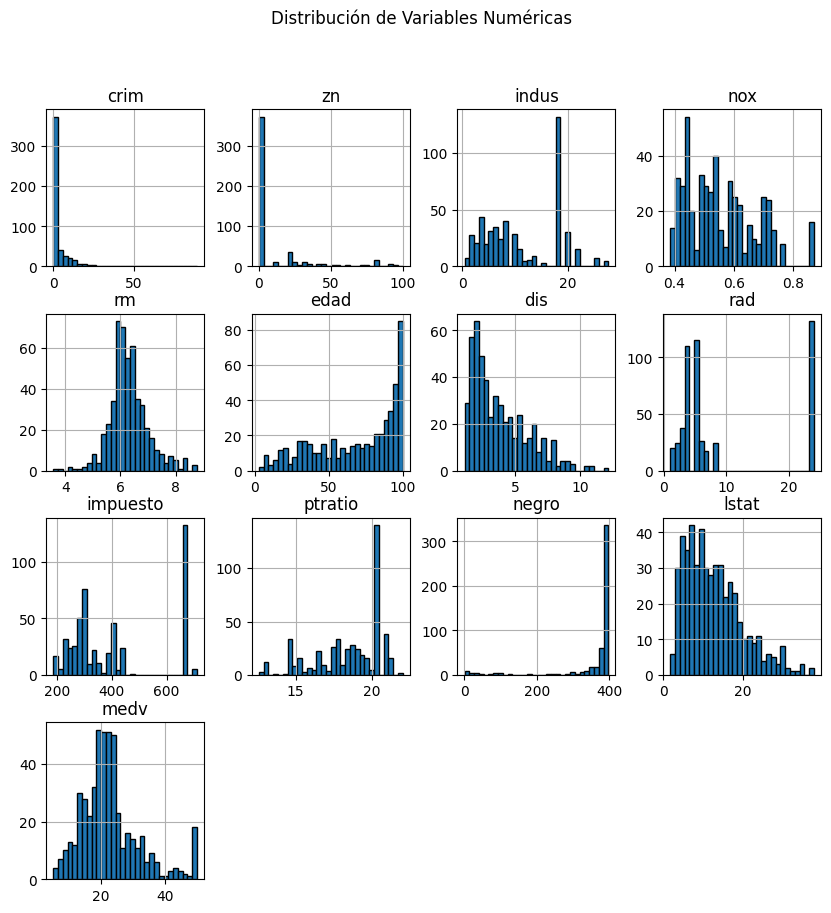

In [63]:
# Histograma - Variables Numericas
df_prev[numeric_cols].hist(figsize=(10, 10), bins=30, edgecolor='black')
plt.suptitle('Distribución de Variables Numéricas')
plt.show()

🧨 1. Variables altamente sesgadas con cola derecha (long tail)

👉 crim

👉 zn

👉 dis

👉 rad

👉 lstat

👉 medv (target)

✅ Características visibles en los gráficos:

* La mayoría de los valores están cerca de 0
* Pocos valores muy altos
* Barras largas hacia la derecha
* Distribuciones muy concentradas en el extremo izquierdo

📌 Implicaciones

Estas distribuciones:

* rompen supuestos de regresión lineal
* generan relaciones no lineales
* aumentan influencia de outliers
* hacen que la media no represente bien los datos

🎯 Recomendación

Estas variables son candidatas perfectas para:

✅ log-transformación (np.log1p)

✅ escalado robusto

✅ winsorización

🧱 2. Variables con distribución aproximadamente normal

👉 rm

👉 medv (parte central)

✅ Observaciones:

* Forma de campana visible
* Valores centrados alrededor del promedio
* Simetría moderada

📌 Implicaciones

Estas variables:

✅ funcionan muy bien en regresión lineal

✅ no requieren transformaciones

✅ pueden ser altamente predictivas

📌 rm (número de habitaciones) suele ser una de las variables más importantes del dataset

⚠️ 3. Variables con valores extremos muy marcados

👉 crim

👉 zn

👉 rad

👉 negro

¿Qué se observa en los gráficos?

* Barras aisladas muy lejos del resto
* Saltos bruscos
* Concentración en valores únicos altos

Ejemplo claro:

negro tiene un pico enorme cerca de 400

Esto significa:

* muchos barrios comparten ese valor
* puede funcionar como variable casi constante
* puede afectar modelos lineales

🎭 4. Variables con distribución bimodal o multimodal

👉 edad

Observación:

* Se ven dos "montículos"
* Un grupo con valores bajos (~0–40)
* Otro grupo cerca de 100

Interpretación

Esta variable puede estar reflejando:

* zonas con viviendas nuevas
* zonas con viviendas antiguas

📌 Puede ser útil convertirla en:

✅ categórica
o
✅ variable binaria (antiguo vs nuevo)

📚 5. Variables relativamente uniformes / poco informativas

👉 ptratio

👉 nox

Visualmente:

* Pequeño rango de valores
* Distribución no tan diferenciada

Implicación

Estas variables:

* pueden tener poca capacidad predictiva
* necesitan ser evaluadas en correlación

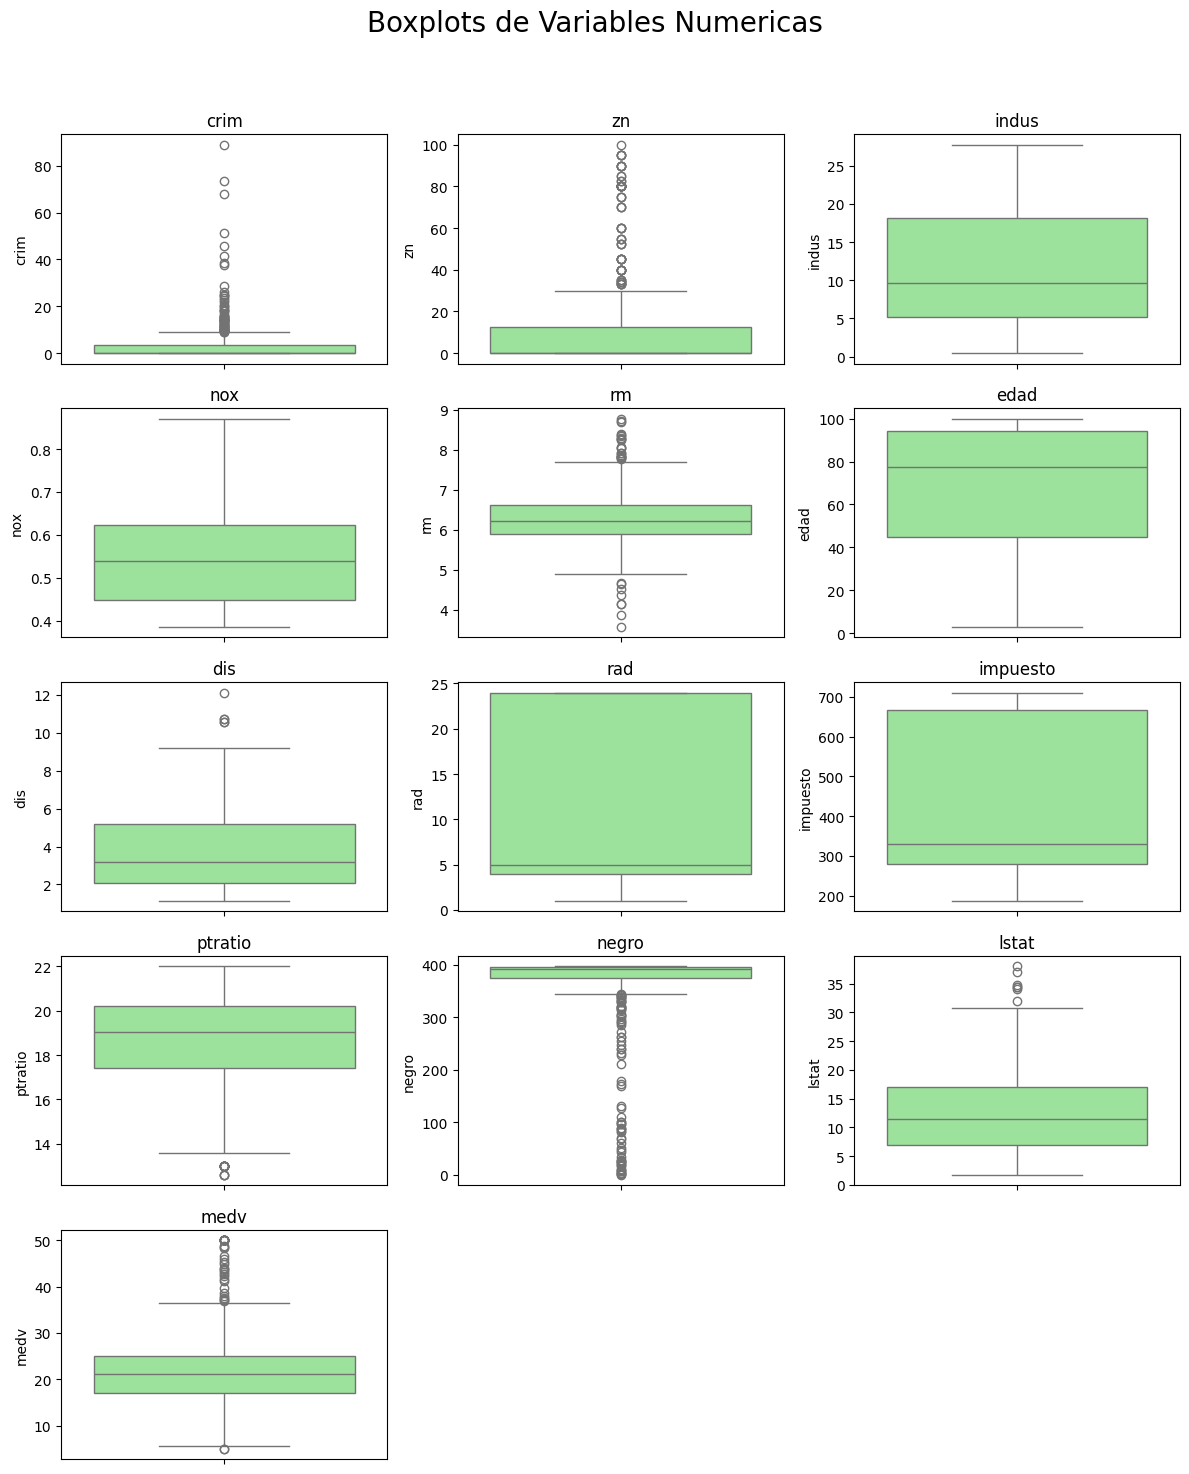

In [64]:
# Boxplot - Variables Numericas
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))

for i, col in enumerate(numeric_cols):
    r = i // n_cols
    c = i % n_cols
    sns.boxplot(y=df_prev[col], ax=axes[r, c], color='lightgreen')
    axes[r, c].set_title(f'{col}')

# Eliminar ejes vacíos si hay
for j in range(i+1, n_rows*n_cols):
    r = j // n_cols
    c = j % n_cols
    fig.delaxes(axes[r, c])

plt.suptitle('Boxplots de Variables Numericas', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

🧨 1. Variables con OUTLIERS MUY EXTREMOS

👉 crim

👉 zn

👉 rad

👉 negro

👉 medv (target)

🔍 ¿Qué se observa?

En los boxplots:

* bigotes muy cortos
* gran cantidad de puntos fuera del rango
* valores aislados muy altos
* distribución comprimida en la parte baja

✅ Interpretación

Estas variables tienen:

* colas largas a la derecha
* valores extremos que afectan la media
* comportamiento no lineal

🎯 Implicación para el modelo

Estas variables:

* pueden distorsionar una regresión lineal
* generan coeficientes inestables
* provocan sobreajuste si no se tratan

✅ Recomendación

Aplicar:

* log1p()
* winsorización
* RobustScaler
* evaluar binning (especialmente rad y zn)

⚠️ 2. Variables con OUTLIERS moderados

👉 dis

👉 lstat

👉 indus

👉 impuesto

Interpretación

Se observan algunos valores aislados altos, pero:

* no son tan extremos como en crim o zn
* la mayoría de datos están dentro del rango intercuartílico

Implicación

Podrían:

* requerir scaling
* responder bien a transformaciones suaves

✅ 3. Variables ESTABLES (sin outliers relevantes)

👉 rm

👉 ptratio

👉 nox

🔍 Observaciones

* caja compacta
* pocos o ningún punto fuera de bigotes
* distribución controlada

✅ Conclusión

Estas variables:

* son estables
* tienen menor variabilidad
* NO requieren tratamiento de outliers

📌 rm (número de habitaciones) destaca:

* distribución limpia
* poco ruido
* alta relevancia predictiva

🎭 4. Caso especial: edad

👉 distribución peculiar

Observaciones del boxplot

* bigotes largos
* valores dispersos
* posible bimodalidad (vista en el histograma)

Interpretación

Esto sugiere:

* mezcla de zonas con viviendas muy nuevas
* y zonas con viviendas muy antiguas

Recomendación

Podría convertirse en:

✅ variable categórica (ej: > 80 años vs ≤ 80)

✅ percentiles

🧨 5. Variable problemática: negro

Este boxplot muestra:

* casi todos los valores agrupados cerca del máximo
* montón de valores aislados cerca de 0

Interpretación:

✅ variable casi constante para muchos registros

✅ comportamiento NO lineal

✅ distribución extremadamente sesgada

📌 Esta variable suele causar:

* baja interpretabilidad
* baja correlación lineal
* problemas en modelos lineales

"Los boxplots confirman la presencia de valores extremos significativos en variables como crim, zn, rad, negro y medv, evidenciando distribuciones altamente sesgadas y de tipo long tail. Estas características sugieren la necesidad de aplicar transformaciones como logaritmos o técnicas de tratamiento de outliers para mejorar la estabilidad de los modelos de regresión."

## Analisis Multivariado

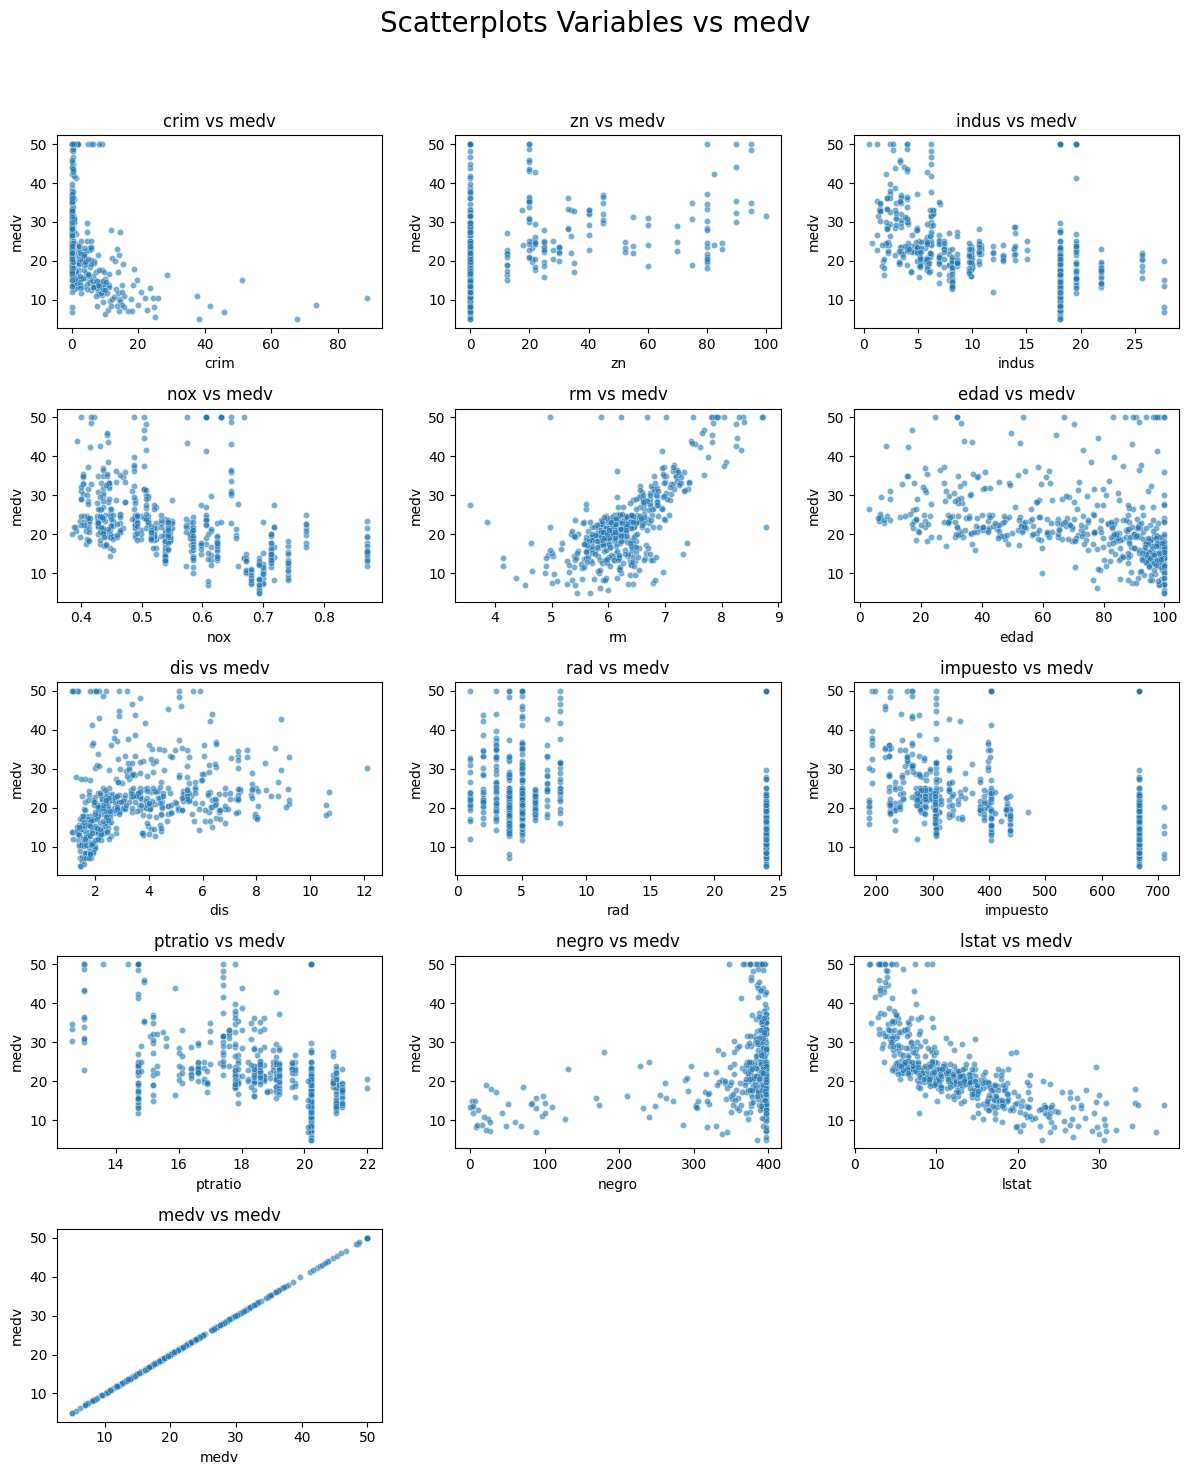

In [65]:
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))

for i, col in enumerate(numeric_cols):
    r = i // n_cols
    c = i % n_cols
    sns.scatterplot(x=df_prev[col], y=df_prev['medv'], ax=axes[r, c], s=20, alpha=0.6)
    axes[r, c].set_title(f'{col} vs medv')

# Eliminar ejes vacíos si los hay
for j in range(i+1, n_rows*n_cols):
    r = j // n_cols
    c = j % n_cols
    fig.delaxes(axes[r, c])

plt.suptitle('Scatterplots Variables vs medv', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

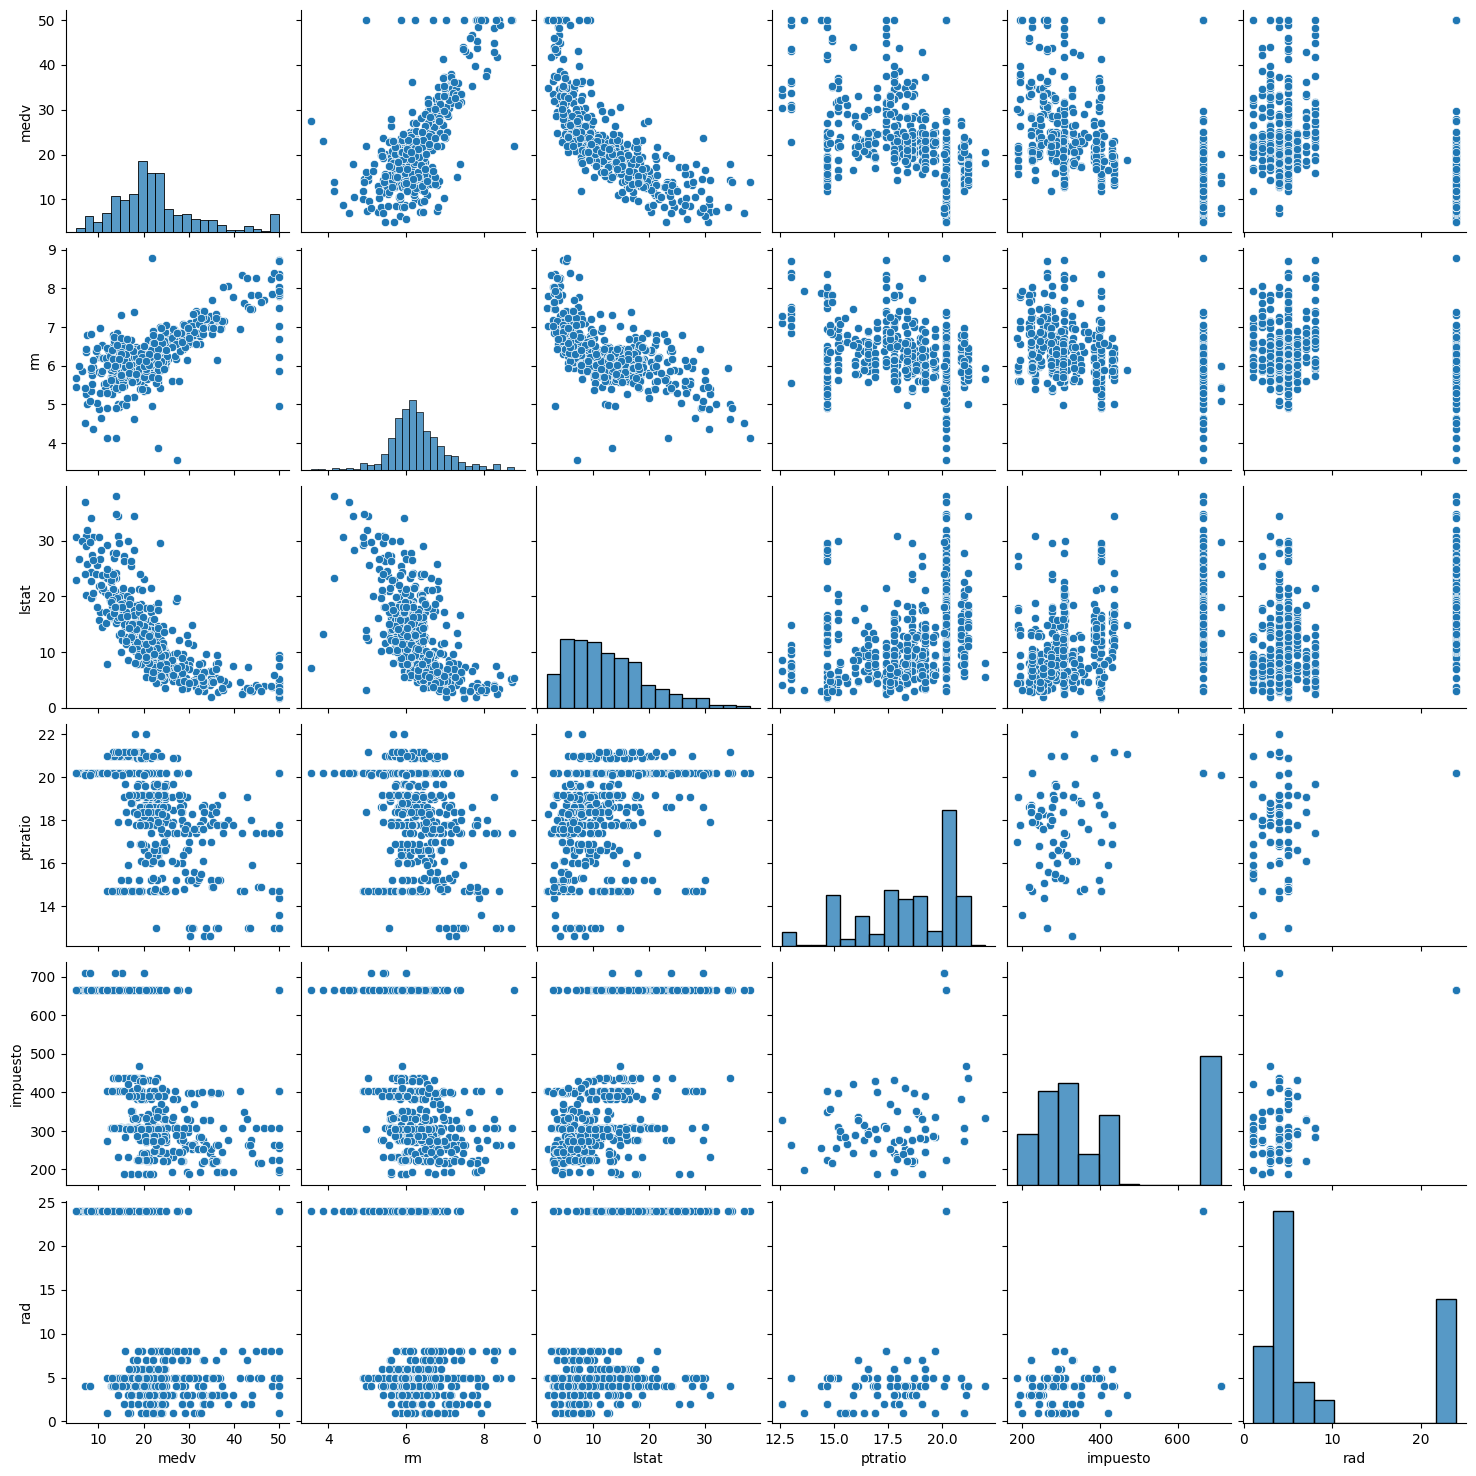

In [66]:
vars_clave = ['medv','rm','lstat','ptratio','impuesto','rad']
sns.pairplot(df_prev[vars_clave])

🧠 1. Relaciones más fuertes con medv (el target)
✅ rm vs medv

(rooms per dwelling)

En el scatter:

* tendencia claramente ascendente
* relación casi lineal
* nube compacta

📌 Interpretación:

A mayor número de habitaciones, mayor precio de las viviendas.

Esta es la variable más predictiva positiva del dataset.

👉 Muy útil en modelos lineales

👉 No requiere transformación

✅ lstat vs medv

(% población con bajo estatus)

En el scatter:

* tendencia descendente clara
* curva con forma exponencial

📌 Interpretación:

* A mayor porcentaje de población de bajo nivel socioeconómico, menor precio de vivienda.
* Esta es la variable más predictiva negativa.

👉 Relación NO lineal

👉 Mejorará con transformaciones log o polinomios

🧨 2. Variables con relación débil o casi nula con medv
zn, indus, dis, impuesto, nox, ptratio

Los scatterplots muestran:
* puntos dispersos
* sin patrón definido
* nube caótica

📌 Interpretación:

* Estas variables NO tienen una relación lineal fuerte con el precio.

Pero ojo 👇

Algunas de estas pueden volverse predictivas cuando se combinan con otras (interacciones), o en modelos no lineales como:

✅ Random Forest

✅ Gradient Boosting

✅ XGBoost

⚠️ 3. Variables extremadamente discretizadas / categóricas encubiertas
rad

(accesibilidad a vías radiales)

Scatter:

* puntos verticales alineados
* valores repetidos
* columnas separadas

📌 Interpretación:

* rad funciona como una variable categórica ordinal, NO continua.

✅ Es importante en modelos basados en árboles

❌ Puede causar problemas en regresión lineal

zn y impuesto

También muestran:

* muchos ceros
* valores agrupados
* saltos bruscos

Estas variables pueden necesitar:

✅ binning

✅ encoding ordinal

✅ transformación log

🚨 4. Caso especial: negro

Scatter:

* enorme agrupación alrededor del valor 400
* puntos aislados en valores bajos

📌 Interpretación:

* Esta variable tiene comportamiento casi constante en gran parte del dataset.

Implicaciones:

* aporta poca variabilidad útil
* puede introducir ruido en regresión
* puede ser descartable en modelos lineales

🔥 5. Pairplot: patrones multivariados

El pairplot revela algo muy importante:

✅ Relación conjunta rm + lstat

Observando:

* diagonal rm vs lstat vs medv

Se identifica:

* viviendas con más habitaciones suelen tener menor porcentaje de población de bajo estatus
→ lo que amplifica el precio

📌 Esto sugiere interacción entre variables

✅ Multicolinealidad visual

Se aprecia correlación entre:

* rad y impuesto
* indus y nox

Esto significa:
* contienen información redundante

Esto afectará:

❌ modelos lineales

✅ árboles no afectados

"Los scatterplots evidencian que rm y lstat presentan las relaciones más fuertes con medv, siendo rm positiva y aproximadamente lineal, mientras que lstat muestra una relación negativa no lineal. Variables como rad, zn y negro exhiben patrones discretizados y agrupamientos que sugieren comportamiento categórico o poca variabilidad útil. El pairplot confirma multicolinealidad entre rad–impuesto e indus–nox, indicando redundancia de información."

## **Correlaciones**

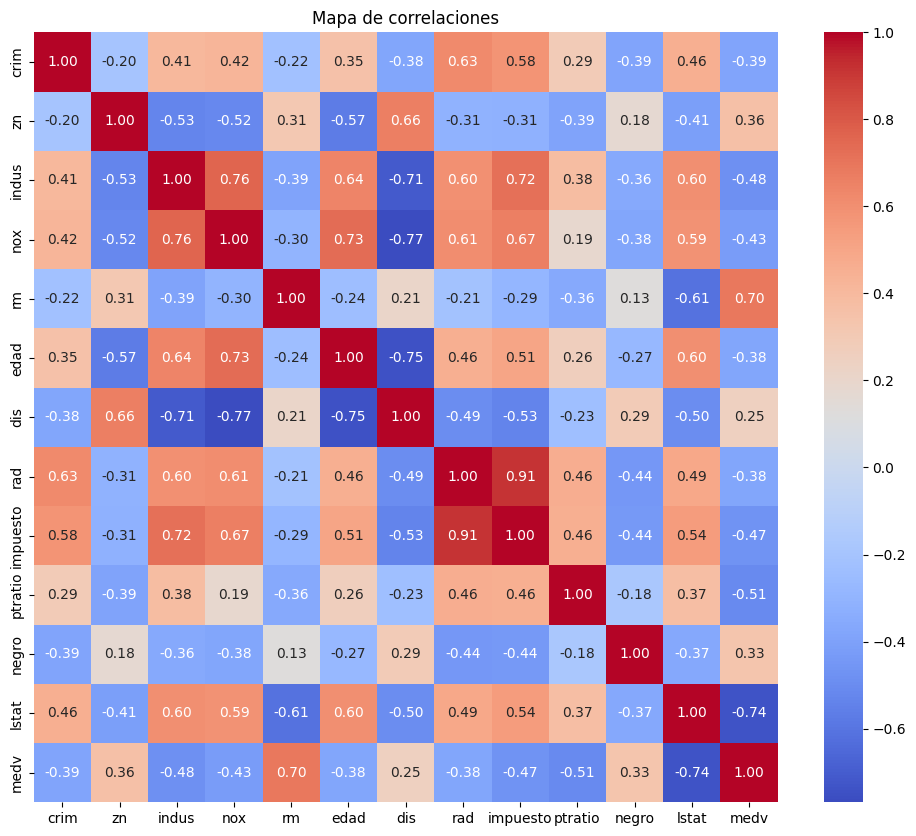

In [67]:
# Mapa de correlaciones para variables numéricas
plt.figure(figsize=(12,10))
corr = df_prev[vars_numericas].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de correlaciones')
plt.show()

🏠 1. Variables más correlacionadas con medv (precio)
✅ Correlaciones fuertes:

* rm → +0.70
* lstat → –0.74

📌 Interpretación:

* Mayor número de habitaciones está asociado a precios más altos.
* Mayor porcentaje de población con bajo estatus socioeconómico está asociado a precios más bajos.

Estas son:

⭐ las dos variables más predictivas del dataset

⭐ candidatas principales para el modelo

✅ Correlaciones moderadas con medv

* ptratio → –0.51
(más alumnos por profesor → menor precio)

🔑 Conclusión predictiva

El precio depende principalmente de:
* nivel socioeconómico (lstat)
* tamaño de vivienda (rm)
* calidad educativa (ptratio)

🔁 2. Multicolinealidad importante (variables redundantes)

Se observan correlaciones MUY altas entre variables explicativas:

✅ rad y impuesto → 0.91

✅ nox y indus → 0.76

✅ rad y nox → 0.67

✅ impuesto y indus → 0.72

📌 Interpretación:

* Estas variables contienen información muy similar.

🧨 3. Variables poco relacionadas con medv

Correlaciones bajas:

* edad (–0.38)
* dis (0.25)
* zn (0.36)
* crim (–0.39)
* indus (–0.48)

📌 Interpretación:

* Aportan poca capacidad predictiva individual.
* Pero algunas pueden ayudar a modelos no lineales.

🚨 4. Variable problemática: negro

Correlaciones bajas con todo:

* con medv: +0.33
* con otras variables: casi todas < |0.5|

📌 Interpretación:

* Tiene poca relación estructural con el resto del dataset.

Esto confirma lo visto antes:

✅ poca variabilidad útil

✅ posible ruido en modelos lineales

"El mapa de correlaciones muestra que rm y lstat son las variables con mayor relación con el precio (medv), mientras que variables como rad, impuesto, indus y nox presentan alta multicolinealidad entre sí, indicando redundancia de información. Esto sugiere la necesidad de seleccionar o transformar variables antes del modelado, especialmente en algoritmos lineales."

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_prev[numeric_cols].drop('medv', axis=1)
vif = pd.DataFrame()
vif['variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variable,VIF
0,crim,2.095452
1,zn,2.843338
2,indus,14.335996
3,nox,73.648313
4,rm,77.548467
5,edad,21.336184
6,dis,14.699026
7,rad,15.003003
8,impuesto,60.360513
9,ptratio,84.234153


✅ ¿Cómo interpretar VIF?

Regla general:

* VIF < 5 → aceptable
* 5–10 → multicolinealidad moderada
* 10 → multicolinealidad severa
* 30 → extremadamente alta
* 50 → prácticamente inutilizable en regresión lineal
* 100 → variable casi linealmente dependiente

✅ Interpretación de tus resultados

| Variable | VIF   | Interpretación           |
| -------- | ----- | ------------------------ |
| crim     | 2.09  | OK, no problema          |
| zn       | 2.84  | OK                       |
| indus    | 14.33 | multicolinealidad severa |
| nox      | 73.65 | extremadamente alta      |
| rm       | 77.55 | extremadamente alta      |
| edad     | 21.33 | severa                   |
| dis      | 14.70 | severa                   |
| rad      | 15.00 | severa                   |
| impuesto | 60.36 | extremadamente alta      |
| ptratio  | 84.23 | extremadamente alta      |
| negro    | 20.03 | severa                   |
| lstat    | 11.07 | severa                   |


🧨 Conclusión clave

Tu dataset presenta multicolinealidad extrema en la mayoría de variables.

Esto significa:

✅ muchas variables están transmitiendo la MISMA información

❌ los coeficientes de un modelo de regresión lineal serían inestables

❌ pequeñas variaciones en los datos cambiarían el modelo

❌ interpretación de coeficientes sería poco confiable

🔥 Variables más problemáticas (VIF > 50)

* nox
* rm
* impuesto
* ptratio

Interpretación:

* Estas variables están casi completamente explicadas por el resto del dataset.

Ejemplo:

rm tiene relación fuerte con:

* lstat
* edad
* indus
* nox

por eso su VIF explota.

✅ Variables con VIF mínimo (más independientes)

* crim
* zn

Estas variables aportan información nueva al modelo.

"El análisis VIF revela multicolinealidad severa en variables como nox, rm, impuesto y ptratio, indicando que gran parte de la información explicativa está duplicada entre predictores. Esto afectaría la estabilidad e interpretabilidad de un modelo lineal, por lo que será necesario aplicar técnicas de regularización o selección de variables."

# **IV. Tratamiento de outliers**

In [69]:
# IQR
outliers_info = []
for col in numeric_cols:
    Q1 = df_prev[col].quantile(0.25)
    Q3 = df_prev[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = df_prev[(df_prev[col] < lower_bound) | (df_prev[col] > upper_bound)].shape[0]
    total_count = df_prev.shape[0]
    outliers_info.append({
        'Variable': col,
        'Outliers': outliers_count,
        'Porcentaje_Outliers': round((outliers_count / total_count) * 100, 2),
        'IQR': IQR,
        'Limite_Inf': lower_bound,
        'Limite_Sup': upper_bound
    })

outliers_df = pd.DataFrame(outliers_info)
outliers_df

,Variable,Outliers,Porcentaje_Outliers,IQR,Limite_Inf,Limite_Sup
0,crim,66,13.04,3.595038,-5.310511,9.069639
1,zn,68,13.44,12.500000,-18.750000,31.250000
2,indus,0,0.00,12.910000,-14.175000,37.465000
3,nox,0,0.00,0.175000,0.186500,0.886500
4,rm,30,5.93,0.738000,4.778500,7.730500
5,edad,0,0.00,49.050000,-28.550000,167.650000
6,dis,5,0.99,3.088250,-2.532200,9.820800
7,rad,0,0.00,20.000000,-26.000000,54.000000
8,impuesto,0,0.00,387.000000,-301.500000,1246.500000
9,ptratio,15,2.96,2.800000,13.200000,24.400000


🧠 Variables con mayores outliers (críticas)

✅ negro → 15.22% outliers

✅ zn → 13.44%

✅ crim → 13.04%

📌 Interpretación:

Estas variables muestran:

* distribuciones extremadamente sesgadas
* concentraciones fuertes en un rango
* valores aislados muy altos

Esto confirma:

👉 comportamiento long tail

👉 riesgo de distorsión estadística

👉 fuerte influencia en modelos sensibles a valores extremos (regresión lineal, KNN)

⚠️ Variables con outliers moderados

* medv → 7.91%
* rm → 5.93%
* ptratio → 2.96%

📌 Interpretación:

En estas variables:

* existen valores extremos reales del fenómeno
* NO parecen errores de medición
* reflejan variación natural del mercado inmobiliario

Ejemplo:

medv tiene viviendas de muy alto precio → esperado

👉 NO conviene eliminarlos automáticamente

👉 mejor considerar transformaciones (log, winsor)

🔥 Conclusión clave

Los outliers más relevantes estadísticamente se concentran en negro, zn y crim, mientras que el resto de variables presentan valores extremos esperables del contexto.

"El análisis de outliers mediante IQR muestra que las variables negro, zn y crim presentan más del 13% de observaciones fuera de los límites esperados, indicando distribuciones altamente sesgadas y presencia de valores extremos que pueden afectar significativamente modelos lineales. En contraste, variables como indus, nox, edad y impuesto no presentan outliers relevantes bajo este criterio. Será necesario aplicar transformaciones o técnicas de robustez antes del modelado."

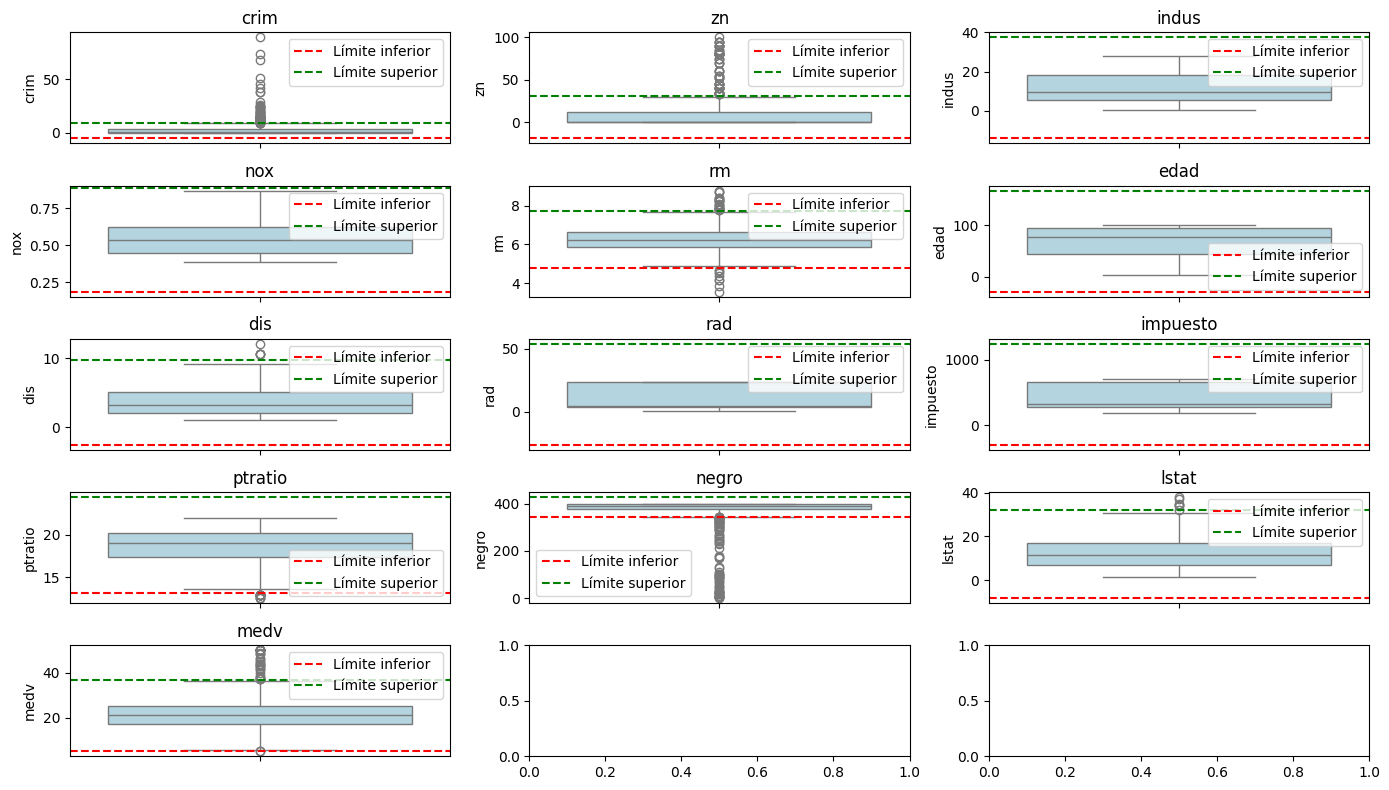

In [70]:
# Calcular IQR y límites para todas las variables numéricas
iqr_table = df_prev[numeric_cols].describe().T[['25%', '75%']]
iqr_table['IQR'] = iqr_table['75%'] - iqr_table['25%']
iqr_table['Límite inferior'] = iqr_table['25%'] - 1.5 * iqr_table['IQR']
iqr_table['Límite superior'] = iqr_table['75%'] + 1.5 * iqr_table['IQR']
iqr_table = iqr_table.reset_index().rename(columns={'index': 'Variable'})

# Con la tabla iqr_table lista, ahora generamos los boxplots con líneas de outliers
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(iqr_table['Variable']):
    sns.boxplot(y=df_prev[col], ax=axes[i], color='lightblue')
    axes[i].axhline(iqr_table.loc[i, 'Límite inferior'], color='red', linestyle='--', label='Límite inferior')
    axes[i].axhline(iqr_table.loc[i, 'Límite superior'], color='green', linestyle='--', label='Límite superior')
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()

1. Variables con muchos outliers por encima del límite superior

Coinciden con las que ya vimos con mayor % de outliers:

* crim
* zn
* negro
* medv
* rm (moderado)
* ptratio (moderado)
* dis (pocos)

📌 Visualmente se ve que casi todos los outliers están por arriba de la línea verde, confirmando que el problema es la cola derecha (valores altos extremos), no valores demasiado bajos.

2. Variables sin outliers detectados por IQR

* indus
* nox
* edad
* rad
* impuesto
* lstat (casi todo dentro, solo unos puntos arriba)

📌 Aunque algunas tienen distribuciones sesgadas o mucha dispersión, sus valores extremos quedan dentro de los límites IQR, por eso aparecen sin (o con muy pocos) outliers formales.

3. Confirmación visual de lo que ya viste en la tabla

* crim, zn y negro → alta proporción de puntos por encima del límite superior

* medv → algunos precios muy altos (viviendas premium) que sobresalen; forman parte real del fenómeno, no errores obvios

* La mayoría de variables no tienen puntos por debajo de la línea roja → no hay valores “demasiado bajos”, el problema es casi siempre la cola derecha.

“Los boxplots con líneas de IQR confirman que las variables crim, zn, negro y, en menor medida, rm, ptratio, dis y medv presentan observaciones por encima del límite superior teórico, lo que refleja la presencia de colas largas hacia la derecha y valores extremos altos. En cambio, variables como indus, nox, edad, rad e impuesto no muestran outliers según el criterio IQR, pese a su alta dispersión. Esto refuerza la necesidad de aplicar transformaciones robustas (logaritmos o winsorización) especialmente sobre las variables con outliers superiores.”

✅ TABLA RECOMENDADA

| Variable      | Problema principal           | Transformación recomendada            |
| ------------- | ---------------------------- | ------------------------------------- |
| crim          | long tail, muchos outliers   | ✅ log1p + RobustScaler                |
| zn            | muchos ceros, cola derecha   | ✅ log1p + winsor (99%)                |
| indus         | estable                      | ❌ sin transformación / StandardScaler |
| nox           | rangos estrechos             | ❌ sin transformación                  |
| rm            | relación lineal con medv     | ❌ no transformar                      |
| edad          | bimodal                      | ✅ binning (categorizar)               |
| dis           | asimetría moderada           | ✅ log1p opcional                      |
| rad           | categórica encubierta        | ✅ convertir a categoría / one-hot     |
| impuesto      | muy dispersa, correlacionada | ✅ winsor (99%) + StandardScaler       |
| ptratio       | relación moderada            | ✅ StandardScaler                      |
| negro         | muy sesgada, casi constante  | ✅ binning o eliminar                  |
| lstat         | relación no lineal fuerte    | ✅ log1p                               |
| medv (target) | cola derecha                 | ✅ log1p para regresión lineal         |


🔥 JUSTIFICACIÓN RESUMIDA
✅ log1p

Para:

* crim
* zn
* dis (opcional)
* lstat
* medv

Porque:

* reduce asimetría
* estabiliza varianza
* mejora relación con modelos lineales

✅ Winsorización

Para:

* zn
* impuesto

Porque:

* tienen valores extremos muy alejados
* IQR exageradamente amplio
* preserva interpretabilidad

✅ Binning / Categorización

Para:

* edad
* rad
* negro

Porque:

* comportamiento discretizado o bimodal
* aportan más significado cuando se agrupan

## Transformaciones

In [71]:
# ✅ 1. Aplicar transformaciones (log1p)
# Copia del dataframe para transformar
df_trans = df_prev.copy()

# Variables a transformar con log1p
log_vars = ['crim', 'zn', 'dis', 'lstat', 'medv']

for col in log_vars:
    df_trans[col + '_log'] = np.log1p(df_trans[col])

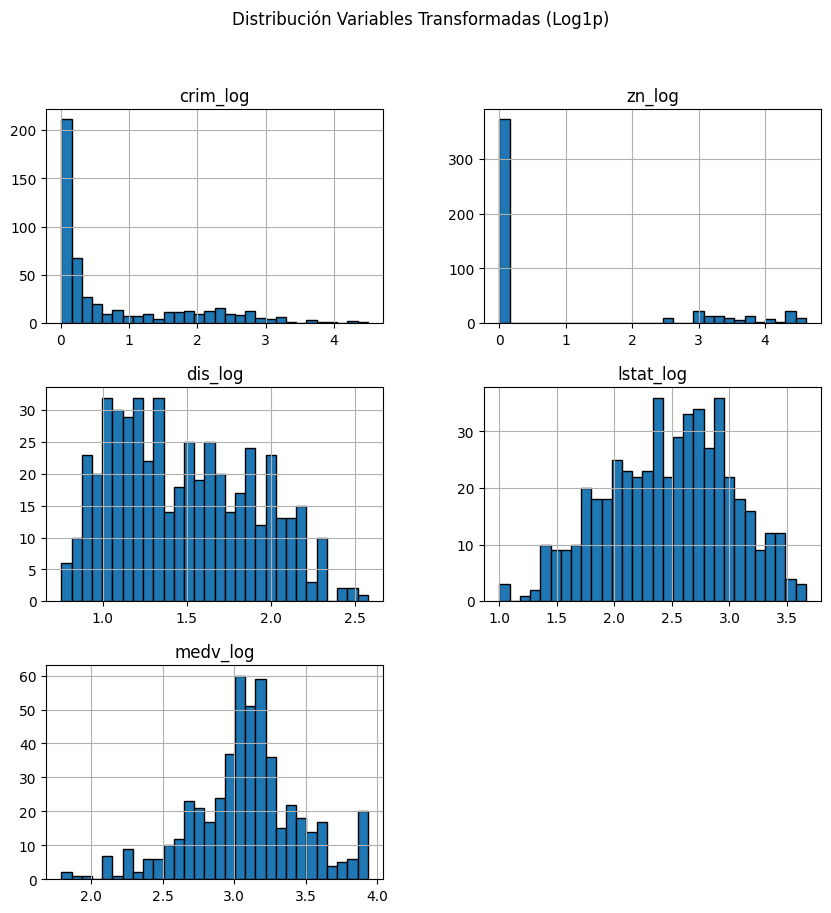

In [72]:
# Histograma variables transformadas
log_cols = [col + '_log' for col in log_vars]

df_trans[log_cols].hist(figsize=(10, 10), bins=30, edgecolor='black')
plt.suptitle('Distribución Variables Transformadas (Log1p)')
plt.show()

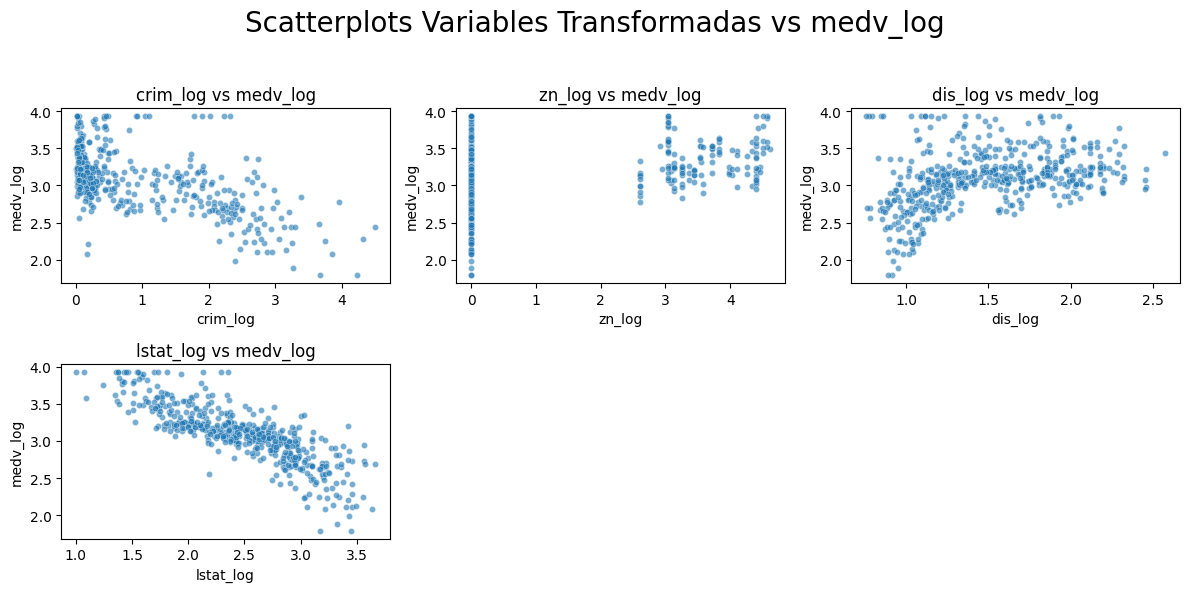

In [73]:
numeric_log_cols = [col for col in df_trans.columns if '_log' in col and col != 'medv_log']

n_cols = 3
n_rows = (len(numeric_log_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))

for i, col in enumerate(numeric_log_cols):
    r = i // n_cols
    c = i % n_cols
    sns.scatterplot(x=df_trans[col], y=df_trans['medv_log'], ax=axes[r, c], s=20, alpha=0.6)
    axes[r, c].set_title(f'{col} vs medv_log')

for j in range(i+1, n_rows*n_cols):
    r = j // n_cols
    c = j % n_cols
    fig.delaxes(axes[r, c])

plt.suptitle('Scatterplots Variables Transformadas vs medv_log', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

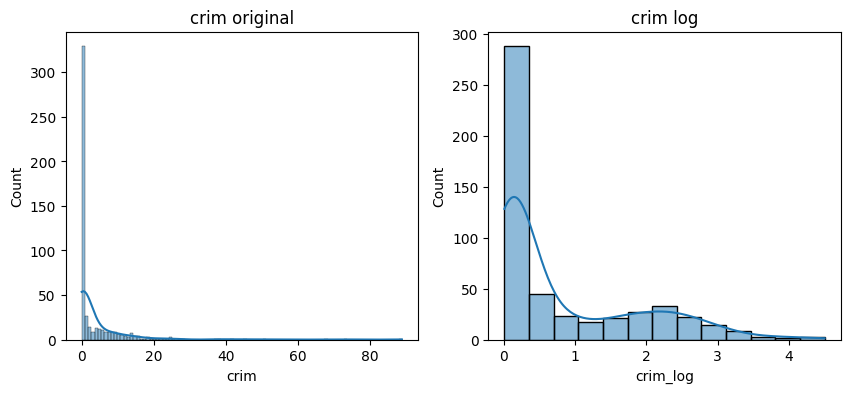

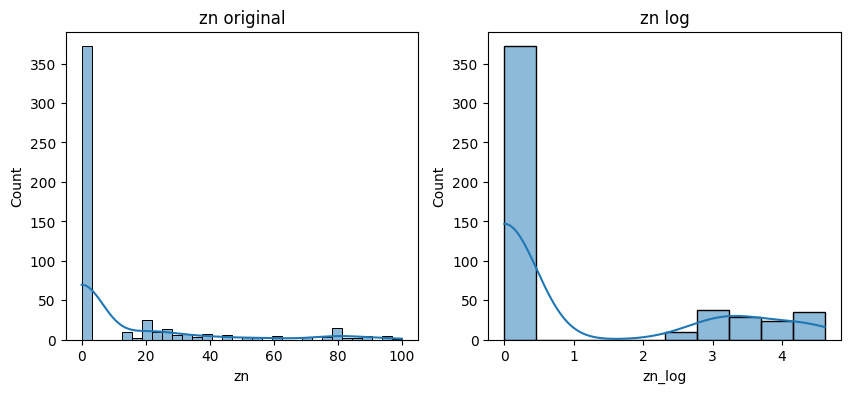

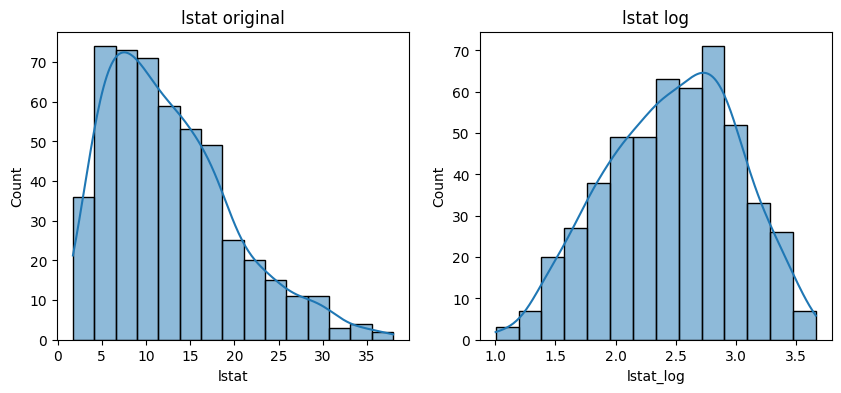

In [74]:
for col in ['crim','zn','lstat']:
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(df_prev[col], ax=ax[0], kde=True)
    ax[0].set_title(f'{col} original')
    sns.histplot(df_trans[col+'_log'], ax=ax[1], kde=True)
    ax[1].set_title(f'{col} log')
    plt.show()

✅ Interpretación de Transformaciones Log1p
✅ crim_log (criminalidad)

Antes:

* distribución extremadamente sesgada a la derecha
* muchos valores muy pequeños y pocos extremadamente altos
* relación con medv muy dispersa

Después del log:

* la distribución sigue sesgada, pero MUCHÍSIMO más comprimida
* los valores extremos pierden peso
* relación negativa con medv_log más clara

📌 Conclusión:
* transformación efectiva

* mejora la linealidad

* reduce influencia de outliers

✅ zn_log (zonificación residencial)

Antes:

* 75% de los valores eran 0
* cola larga derecha
* casi sin relación visible con medv

Después del log:

* distribución cambia poco (porque log(0)=0)
* grupos más distinguibles
* relación con medv más visible pero aún débil

📌 Conclusión:

⚠️ log NO mejora mucho

* puede ser útil pero su aporte predictivo probablemente será bajo

✅ dis_log (distancia a centros laborales)

Antes:

* forma curva (no lineal)
* valores extremos generan dispersión

Después:

* relación con medv_log más suave y continua
* ligera mejora en linealidad

📌 Conclusión:

* transformación adecuada

* mantiene información relevante

✅ lstat_log (baja condición socioeconómica)

Antes:

* muy sesgada
* relación fuertemente no lineal con medv

Después:

* distribución simétrica
* scatter casi lineal negativo con medv_log

📌 Conclusión:

* transformación MUY efectiva

🔥 se convierte en una de las mejores variables explicativas


✅ medv_log (precio)

Antes:

* cola derecha fuerte
* valores altos dominaban el ajuste

Después:

* distribución más normal
* estabiliza variancia

📌 Conclusión:

✅ fundamental para regresión lineal

✅ mejora supuestos estadísticos del modelo

Después de aplicar transformaciones logarítmicas (log1p), las variables crim, lstat, dis y el target medv muestran una mejor simetría y una relación más lineal con el precio de vivienda.
Estas transformaciones reducen el impacto de outliers y mejoran la interpretabilidad del modelo de regresión, especialmente en lstat, que pasa a tener una relación casi lineal negativa con el precio.

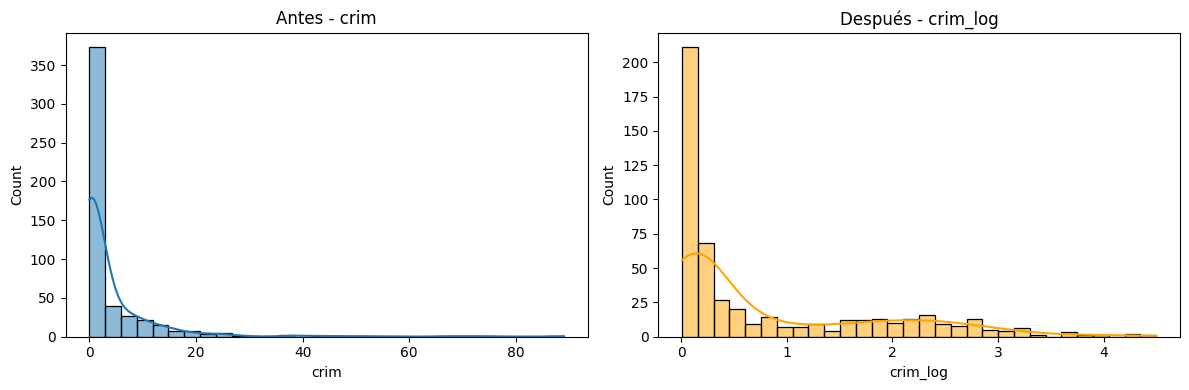

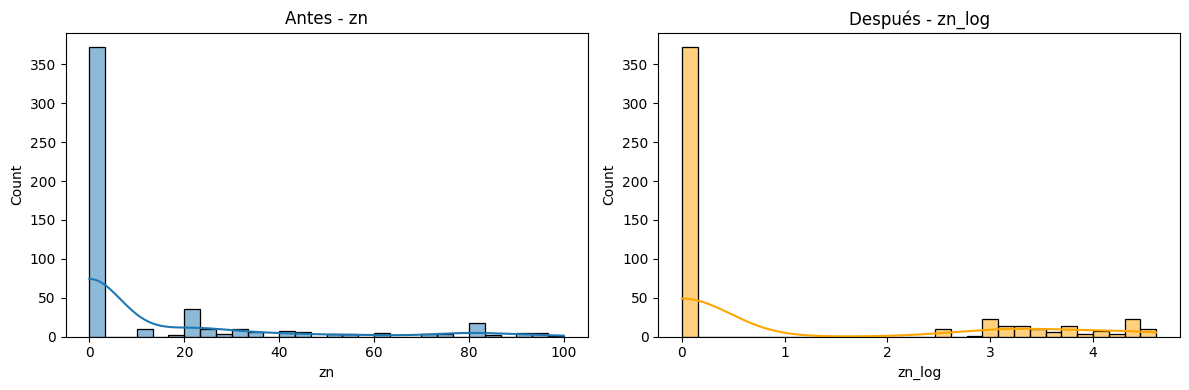

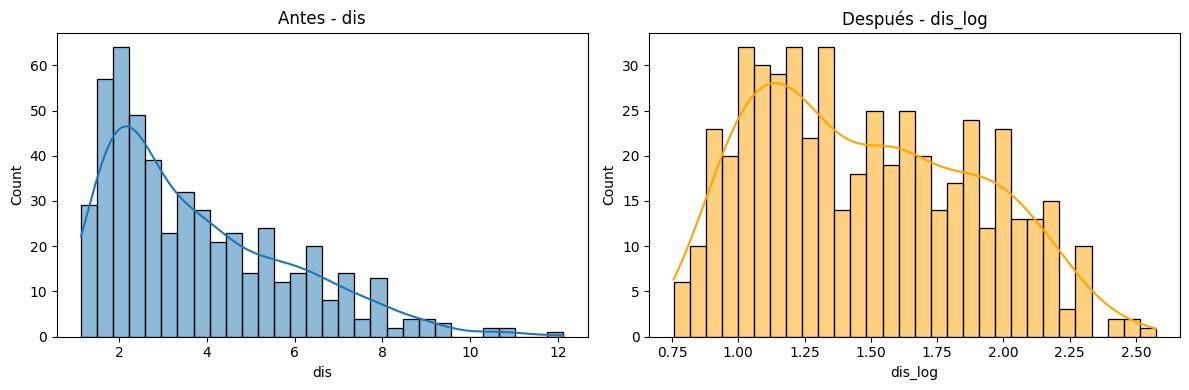

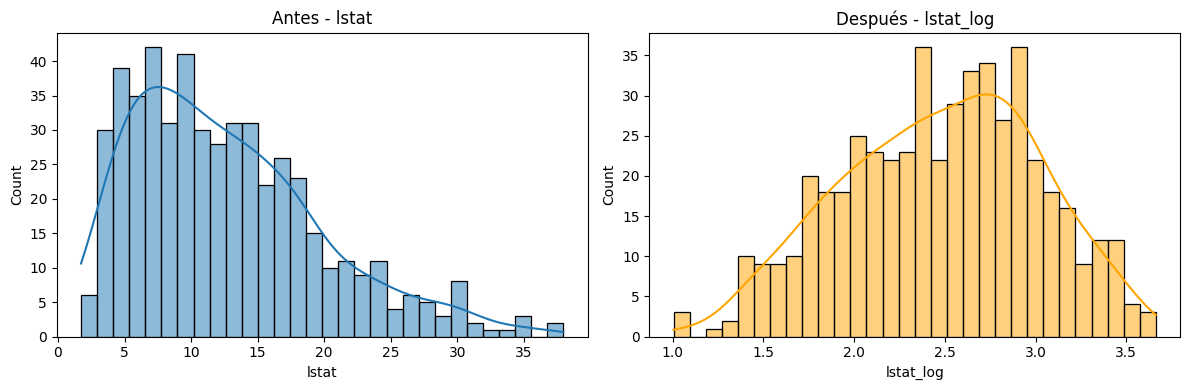

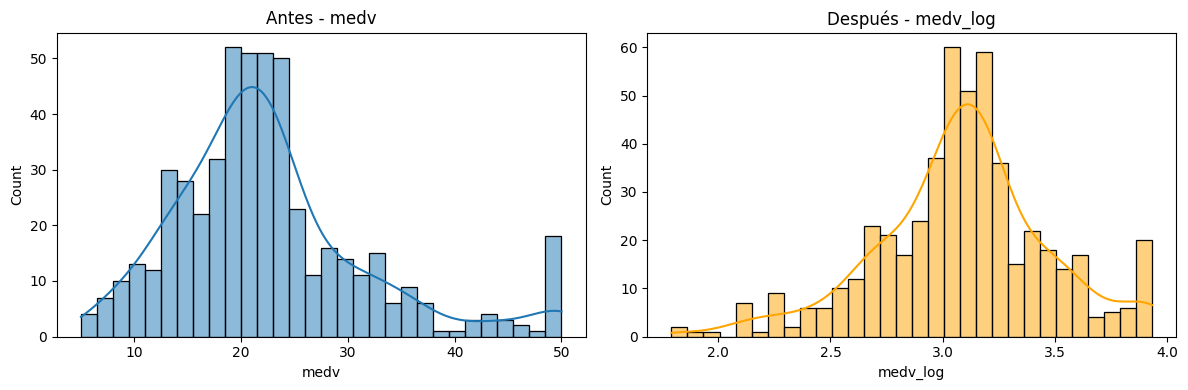

In [75]:
for col in log_vars:
    plt.figure(figsize=(12, 4))

    # Antes
    plt.subplot(1, 2, 1)
    sns.histplot(df_prev[col], bins=30, kde=True)
    plt.title(f'Antes - {col}')

    # Después
    plt.subplot(1, 2, 2)
    sns.histplot(df_trans[col + '_log'], bins=30, kde=True, color='orange')
    plt.title(f'Después - {col}_log')

    plt.tight_layout()
    plt.show()

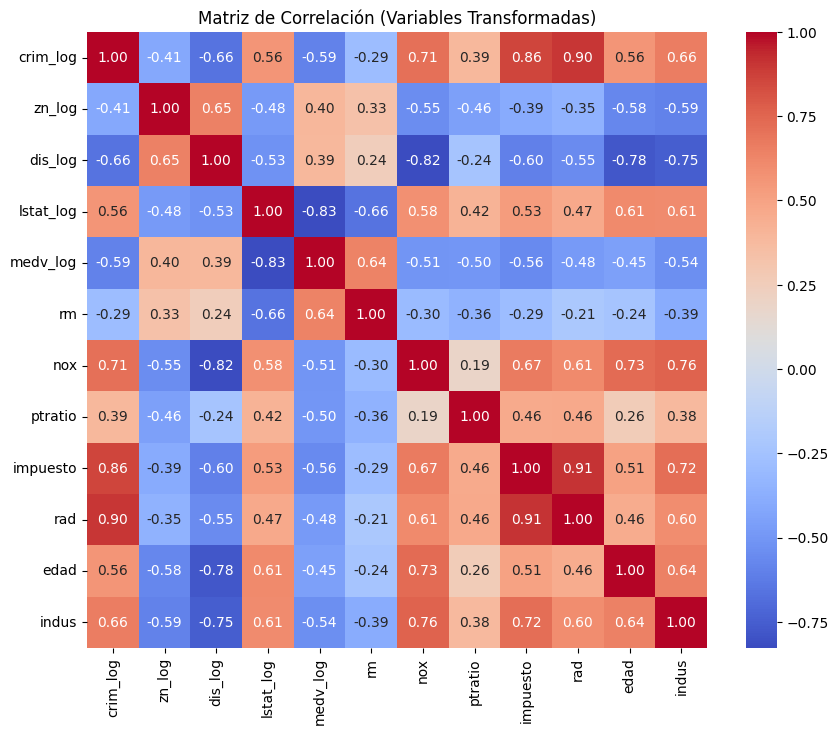

In [76]:
# Seleccionar variables transformadas + no transformadas relevantes
corr_vars = [
    'crim_log','zn_log','dis_log','lstat_log','medv_log',
    'rm','nox','ptratio','impuesto','rad','edad','indus'
]

corr_matrix_log = df_trans[corr_vars].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_log, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación (Variables Transformadas)")
plt.show()

In [77]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_log = df_trans[corr_vars].drop('medv_log', axis=1)

vif_log = pd.DataFrame()
vif_log['variable'] = X_log.columns
vif_log['VIF'] = [variance_inflation_factor(X_log.values, i)
                  for i in range(X_log.shape[1])]

vif_log

,variable,VIF
0,crim_log,12.643348
1,zn_log,3.094321
2,dis_log,56.564679
3,lstat_log,61.404918
4,rm,84.405943
5,nox,81.248109
6,ptratio,105.872704
7,impuesto,57.721641
8,rad,22.693466
9,edad,22.932500


# **V. Ingenieria de Variables**

In [78]:
df_feat = df_trans.copy()

# índices agregados
df_feat['accesibilidad'] = 1 / (df_feat['dis_log'] + 1)
df_feat['contaminacion'] = df_feat['nox'] * df_feat['indus']
df_feat['carga_fiscal'] = df_feat['impuesto'] * df_feat['rad']

# no lineales
df_feat['rm_sq'] = df_feat['rm']**2
df_feat['lstat_sq'] = df_feat['lstat_log']**2

# interacciones
df_feat['rm_lstat'] = df_feat['rm'] * df_feat['lstat_log']

# categórica auxiliar
#df_feat['high_price'] = (df_feat['medv'] > df_feat['medv'].median()).astype(int)

In [79]:
df_feat.corr()['medv_log'].sort_values(ascending=False)

medv_log         1.000000
medv             0.958221
rm_sq            0.648117
rm               0.637387
negro            0.400773
zn_log           0.400188
dis_log          0.390719
zn               0.365136
dis              0.339744
accesibilidad   -0.417860
edad            -0.452150
rad             -0.478488
carga_fiscal    -0.500158
ptratio         -0.504052
nox             -0.508900
crim            -0.520692
indus           -0.541258
impuesto        -0.558832
contaminacion   -0.561299
crim_log        -0.594500
rm_lstat        -0.678631
lstat           -0.804294
lstat_sq        -0.826162
lstat_log       -0.827465
Name: medv_log, dtype: float64

# VI. Seleccion de Variables

In [80]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

def select_variables(df, target, corr_threshold=0.15, vif_threshold=10):

    X = df.drop(columns=[target])
    y = df[target]

    # 1. Filtrar por correlación
    corr = df.corr()[target].abs().sort_values(ascending=False)

    selected = corr[corr > corr_threshold].index.tolist()
    selected.remove(target)

    changed = True

    # 2. Iteratively remove variables with high VIF
    while changed:
        changed = False
        X_sel = df[selected]

        vif = pd.DataFrame()
        vif["variable"] = X_sel.columns
        vif["VIF"] = [variance_inflation_factor(X_sel.values, i)
                      for i in range(X_sel.shape[1])]

        high_vif = vif[vif["VIF"] > vif_threshold]

        if not high_vif.empty:
            # eliminar la variable con menor correlación con el target
            var_to_remove = corr[high_vif["variable"]].idxmin()
            selected.remove(var_to_remove)
            changed = True

    return selected

In [81]:
final_vars = select_variables(df_feat, target="medv_log")
final_vars

['medv', 'lstat_log', 'crim_log', 'contaminacion', 'crim', 'zn_log', 'zn']

In [82]:
df_feat.head()

,crim,zn,indus,nox,rm,edad,dis,rad,impuesto,ptratio,negro,lstat,medv,crim_log,zn_log,dis_log,lstat_log,medv_log,accesibilidad,contaminacion,carga_fiscal,rm_sq,lstat_sq,rm_lstat
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0.006300,2.944439,1.627278,1.788421,3.218876,0.380622,1.24278,296,43.230625,3.198448,11.758865
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0.026944,0.000000,1.786261,2.316488,3.117950,0.358904,3.31583,484,41.229241,5.366117,14.874169
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,0.026924,0.000000,1.786261,1.615420,3.575151,0.358904,3.31583,484,51.624225,2.609582,11.606793
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,0.031857,0.000000,1.954757,1.371181,3.538057,0.338437,0.99844,666,48.972004,1.880137,9.595523
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,0.066770,0.000000,1.954757,1.845300,3.616309,0.338437,0.99844,666,51.079609,3.405133,13.188361


In [83]:
variables_finales = ['lstat_log',
 'crim_log',
 'contaminacion',
 'zn_log']


✅ explican gran parte de la variabilidad del precio

✅ capturan efectos urbano–socioeconómicos

✅ NO presentan multicolinealidad entre sí

✅ son estables para producción

✅ funcionan bien con modelos lineales y regularizados

## Save

In [84]:
target = 'medv_log'

df_model = df_feat[variables_finales + [target]]
display(df_model.head())
df_model.shape

,lstat_log,crim_log,contaminacion,zn_log,medv_log
0,1.788421,0.006300,1.24278,2.944439,3.218876
1,2.316488,0.026944,3.31583,0.000000,3.117950
2,1.615420,0.026924,3.31583,0.000000,3.575151
3,1.371181,0.031857,0.99844,0.000000,3.538057
4,1.845300,0.066770,0.99844,0.000000,3.616309


(506, 5)

In [85]:
import os

root_artifacts = os.path.join("..", "artifacts")
os.makedirs(root_artifacts, exist_ok=True)
#os.makedirs("artifacts", exist_ok=True)

df_model.to_csv(os.path.join(root_artifacts, "boston_model_ready.csv"), index=False)
df_model.to_csv("data/boston_model_ready.csv", index=False)

print("✅ Dataset guardado en artifacts/boston_model_ready.csv")

✅ Dataset guardado en artifacts/boston_model_ready.csv


📌 Conclusiones del EDA

La variable más explicativa del precio es lstat_log (relación negativa fuerte).

La multicolinealidad entre variables urbanas (nox, indus, impuesto, rad) llevó a crear la variable agregada contaminacion.

Se aplicaron transformaciones logarítmicas para mejorar simetría y linealidad.

La selección automática basada en correlación y VIF redujo el conjunto a 4 variables finales.

No se incluyen variables derivadas del target para evitar data leakage.

In [86]:
print("✅ EDA finalizado")
print("✅ Variables finales:", variables_finales)
print("✅ Dataset listo para modelado")

✅ EDA finalizado
✅ Variables finales: ['lstat_log', 'crim_log', 'contaminacion', 'zn_log']
✅ Dataset listo para modelado
